In [1]:
from copy import deepcopy
import numpy as np 
import wandb
from sklearn.datasets import make_classification
import tensorflow as tf

import matplotlib as mpl 
mpl.rcParams['figure.facecolor'] = "white"
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

In [18]:
#Function used for WandB sweep
def train():

    config_defaults = {
        'n_layers': 3,
        'layer_size': 32,
        'weight_decay': 0,
        'lr': 1e-3,
        'optimizer': 'sgd',
        'batch_size': 32,
        'init_method': 'random',
        'activation': 'relu',
        'epochs': 5
    }

    wandb.init(config=config_defaults, magic=True)

    fashion_mnist = tf.keras.datasets.fashion_mnist
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    train_images = flatten(train_images / 255.0)
    test_images = flatten(test_images / 255.0)   

    train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, shuffle=True)

    model = NeuralNet(create_layers(wandb.config.n_layers, 
                                    wandb.config.layer_size, 
                                    wandb.config.activation, 
                                    wandb.config.weight_decay,
                                    wandb.config.init_method))

    
    model.compile(loss=CrossEntropyLossFromLogits(), optimizer=get_optimizer(wandb.config.optimizer, wandb.config.lr))
    
    model.fit(train_images, train_labels, val_images, val_labels, batch_size=wandb.config.batch_size, epochs=wandb.config.epochs)

   


# Templates of Classes

In [3]:
"""
Module to create template classes for Autodifferentiable losses/activations/layers
"""


class AutoDiffFunction():
    """Format for any function in general which has to be auto-differentiable
    """

    def __init__(self, *args, **kwds) -> None:
        self.saved_for_backward = {}
        self.grad = {}

    def __call__(self, *args, **kwds):

        output = self.forward(*args, **kwds)
        self.grad = self.compute_grad(*args, **kwds)
        return output

    def forward(self, *args, **kwds):
        pass

    def compute_grad(self, *args, **kwds):
        pass

    def backward(self, *args, **kwds):
        pass


class Layer(AutoDiffFunction):
    """Format to create your own custom layer for the model
    """
    def __init__(self, *args, **kwds) -> None:
        super().__init__(*args, **kwds)

        self.weights = {}
        self.optimizer = None

    def initialize_weights(self, *args, **kwds):
        pass

    def update_weights(self):

        self.optimizer.step(self)


class Loss(AutoDiffFunction):
    """Format to create a custom loss function
    """

    def forward(self, y_true, y_pred):
        pass 

    def backward(self):
        return self.grad["x"]

    def compute_grad(self, y_true, y_pred):
        pass


class Optimizer():
    """Format to create a custom optimizer
    """
    def __init__(self, *args, **kwds):
        self.remember = {}
        pass

    def add_params(self, *args, **kwds):
        pass

    def step(self, layer):
        pass    

# Activation Functions

In [4]:
class Sigmoid(AutoDiffFunction):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        self.saved_for_backward = 1/(1 + np.exp(-x))
        return self.saved_for_backward

    def compute_grad(self, x):
        y = self.saved_for_backward

        return {"x": y*(1-y)}

    def backward(self, dy):
        return dy * self.grad["x"]      


class RelU(AutoDiffFunction):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        self.saved_for_backward = np.where(x>0.0, 1.0, 0.0)

        return x * self.saved_for_backward

    def compute_grad(self, x):
        return {"x": self.saved_for_backward}

    def backward(self, dy):
        return dy * self.grad["x"]
    
class Tanh(AutoDiffFunction):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        self.saved_for_backward = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

        return self.saved_for_backward

    def compute_grad(self, x):
        y = self.saved_for_backward

        return {"x": 1 - y**2}

    def backward(self, dy):
        return dy * self.grad["x"]
    
class Softmax(AutoDiffFunction):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        v = np.exp(x)
        self.saved_for_backward = v

        return v / np.sum(v, axis=1, keepdims=True)

    def compute_grad(self, x):
        pass

    def backward(self, dy):
        return dy * self.grad["x"]

# Layers

In [5]:
class FC(Layer):
    def __init__(self, in_dim, out_dim, weight_decay=None, init_method="random") -> None:
        super().__init__()
        self.weight_decay = weight_decay
        self.init_method = init_method
        self.initialize_weights(in_dim, out_dim)

    def initialize_weights(self, in_dim, out_dim):
        
        if self.init_method == "random":
            scaling_factor = 1/np.sqrt(in_dim)
            self.weights["w"] = np.random.randn(in_dim, out_dim) * scaling_factor
            self.weights["b"] = np.random.randn(1, out_dim) * scaling_factor
        elif self.init_method == "xavier":
            lim = np.sqrt(6 / (in_dim + out_dim))
            self.weights["w"] = np.random.uniform(low=-lim, high=lim, size=(in_dim, out_dim))
            self.weights["b"] = np.random.uniform(low=-lim, high=lim, size=(1, out_dim))

    def compute_grad(self, x):
        
        gradients = {}

        # y = x * w + b        
        # we compute gradients wrt w and x 
        # gradient wrt b is not required explicitly since we know that it's value is 1
        gradients["w"] = self.saved_for_backward["x"].T
        gradients["x"] = self.weights["w"].T

        return gradients


    def forward(self, x):
        output = x @ self.weights["w"] + self.weights["b"]
        self.saved_for_backward["x"] = x
        
        return output

    def backward(self, dy):
        
        # calculating gradients wrt input to pass on to previous layer for backprop
        dx = dy @ self.grad["x"]
        
        # calculating gradients wrt weights
        dw = self.grad["w"] @ dy
        db = np.sum(dy, axis=0, keepdims=True)

        # accomodating for weight_decay / regularization
        if self.weight_decay:
            dw = dw + 2 * self.weight_decay * self.weights["w"]
            db = db + 2 * self.weight_decay * self.weights["b"]

        self.absolute_gradients = {"w": dw, "b": db}

        return dx

    def update_weights(self):
        self.optimizer.step(self)

# Loss Functions

In [6]:
class CrossEntropyLossFromLogits(Loss):
    def __init__(self) -> None:
        super().__init__()
        self.n_classes = None

    @staticmethod
    def softmax(x):
        v = np.exp(x)
        return v / np.sum(v, axis=1, keepdims=True)

    def encode(self, y): 
        encoded_y = np.zeros(shape=(len(y), self.n_classes))

        for i in range(len(y)):
            encoded_y[i,y[i]] = 1

        return encoded_y

    def forward(self, y_pred, y_true):
         
        probabilities = self.softmax(y_pred)
        y_true_encoded = self.encode(y_true)

        loss_value = np.mean(np.sum(- y_true_encoded * np.log(probabilities), axis=1))

        self.saved_for_backward["probabilities"] = probabilities
        self.saved_for_backward["y_true"] = y_true_encoded

        return loss_value

    def compute_grad(self, y_pred, y_true):

        return {"x": self.saved_for_backward["probabilities"] - self.saved_for_backward["y_true"]}
    
class MSELossFromLogits(Loss):
    def __init__(self) -> None:
        super().__init__()
        self.n_classes = None

    @staticmethod
    def softmax(x):
        maxes_vec = np.expand_dims(np.amax(x,axis=1), axis=1)
        maxes_arr = np.tile(maxes_vec, (1,x.shape[1]))
        v = np.exp(x - maxes_arr)

        return v / np.sum(v, axis=1, keepdims=True)

    def encode(self, y): 
        encoded_y = np.zeros(shape=(len(y), self.n_classes))

        for i in range(len(y)):
            encoded_y[i,y[i]] = 1

        return encoded_y
    
    @staticmethod
    def indicator(i, j):
        ind = {True: 1, False: 0}
        return ind[i==j]

    def forward(self, y_pred, y_true):
         
        probabilities = self.softmax(y_pred)
        y_true_encoded = self.encode(y_true)

        loss_value = np.mean(np.sum((probabilities - y_true_encoded)**2, axis=1))

        self.saved_for_backward["probabilities"] = probabilities
        self.saved_for_backward["y_true"] = y_true_encoded

        return loss_value

    def compute_grad(self, y_pred, y_true):

        probs = self.saved_for_backward["probabilities"]
        labels = self.saved_for_backward["y_true"]
        grad = np.zeros(shape=(len(y_true), self.n_classes))
        
        for point_counter in range(len(y_true)):
            res = 0
            for i in range(self.n_classes):
                for j in range(self.n_classes):
                    
                    res = probs[point_counter, j] * (probs[point_counter, j] - labels[point_counter, j]) * (self.indicator(i,j) - probs[point_counter, i])
                
                grad[point_counter, i] = res
        
        return {"x": grad}

# Optimizers

In [17]:
class SGD(Optimizer):
    def __init__(self, lr=1e-2):
        super().__init__()
        self.lr = lr

    def step(self, layer):

        for weight_name, _ in layer.weights.items():
            layer.weights[weight_name] = layer.weights[weight_name] - self.lr * layer.absolute_gradients[weight_name]
            
class Momentum(Optimizer):
    def __init__(self, lr=1e-3, gamma=0.9):
        super().__init__()
        self.lr = lr
        self.gamma = gamma
        
    def step(self, layer):
        
        #Initialise update history
        if self.remember == {}:
            for weight_name, weight in layer.weights.items():
                self.remember[weight_name] = {}
                self.remember[weight_name]["v"] = np.zeros_like(weight)
        
        #Momentum update rule
        for weight_name, weight in layer.weights.items():
            self.remember[weight_name]["v"] = self.gamma * self.remember[weight_name]["v"] + \
                                                self.lr * layer.absolute_gradients[weight_name]
            layer.weights[weight_name] = layer.weights[weight_name] - self.remember[weight_name]["v"]

class NAG(Optimizer):
    def __init__(self, lr=1e-3, gamma=0.9) -> None:
        super().__init__()
        self.lr = lr
        self.gamma = gamma 

    def step(self, layer):

        if self.remember == {}:
            for weight_name, weight in layer.weights.items():
                self.remember[weight_name] = {}
                self.remember[weight_name]["v"] = np.zeros_like(weight)

        for weight_name, weight in layer.weights.items():
            layer.weights[weight_name] = layer.weights[weight_name] + (self.gamma**2) * self.remember[weight_name]["v"] - \
                                            (1 + self.gamma) * self.lr * layer.absolute_gradients[weight_name]

            self.remember[weight_name]["v"] = self.remember[weight_name]["v"] * self.gamma - \
                                                self.lr * layer.absolute_gradients[weight_name]

class RMSprop(Optimizer):
    def __init__(self, lr=1e-3, beta=0.9, epsilon=1e-7):
        super().__init__()
        self.lr = lr
        self.beta = beta
        self.epsilon = epsilon
        
    def step(self, layer):
        
        #Initialise update history
        if self.remember == {}:
            for weight_name, weight in layer.weights.items():
                self.remember[weight_name] = {}
                self.remember[weight_name]["v"] = np.zeros_like(weight)
        
        #RMSprop update rule
        for weight_name, weight in layer.weights.items():
            self.remember[weight_name]["v"] = self.beta * self.remember[weight_name]["v"] + \
                                                (1 - self.beta) * (layer.absolute_gradients[weight_name] ** 2)
            layer.weights[weight_name] = layer.weights[weight_name] - (self.lr / (np.sqrt(self.remember[weight_name]["v"] + \
                                                self.epsilon))) * layer.weights[weight_name]

class Adam(Optimizer):
    def __init__(self, lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7):
        super().__init__()
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.t = 1
        
    def step(self, layer):
        
        #Initialise update history
        if self.remember == {}:
            for weight_name, weight in layer.weights.items():
                self.remember[weight_name] = {}
                self.remember[weight_name]["v"] = np.zeros_like(weight)
                self.remember[weight_name]["m"] = np.zeros_like(weight)
        
        #Adam update rule
        for weight_name, weight in layer.weights.items():
            
            #Update m_t and v_t
            self.remember[weight_name]["m"] = self.beta_1 * self.remember[weight_name]["m"] + \
                                                (1 -self.beta_1) * layer.absolute_gradients[weight_name]
            
            self.remember[weight_name]["v"] = self.beta_2 * self.remember[weight_name]["v"] + \
                                                (1 - self.beta_2) * (layer.absolute_gradients[weight_name]**2)
            
            #Bias correction
            m_hat = self.remember[weight_name]["m"]/(1 - self.beta_1 ** self.t)
            v_hat = self.remember[weight_name]["v"]/(1 - self.beta_2 ** self.t)
            
            #Update parameters
            layer.weights[weight_name] = layer.weights[weight_name] - (self.lr / (np.sqrt(v_hat + self.epsilon))) * m_hat
            
        self.t += 1
            
class Nadam(Optimizer):
    def __init__(self, lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-7):
        super().__init__()
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.t = 1

    def step(self, layer):
        
        # we have 2 parameters to remember m(t) and v(t) for all weights in the layer
        if self.remember == {}:
            for weight_name, weight in layer.weights.items():
                self.remember[weight_name] = {}
                self.remember[weight_name]["v"] = np.zeros_like(weight)
                self.remember[weight_name]["m"] = np.zeros_like(weight)

        for weight_name, weight in layer.weights.items():
            
            self.remember[weight_name]["m"] = self.beta_1 * self.remember[weight_name]["m"] + \
                                                (1 -self.beta_1) * layer.absolute_gradients[weight_name]

            self.remember[weight_name]["v"] = self.beta_2 * self.remember[weight_name]["v"] + \
                                                (1 - self.beta_2) * layer.absolute_gradients[weight_name]**2

            # bias correction step 
            m_hat = self.remember[weight_name]["m"]/(1 - self.beta_1 ** self.t)
            v_hat = self.remember[weight_name]["v"]/(1 - self.beta_2 ** self.t)

            d = self.lr / (np.sqrt(v_hat) + self.epsilon) * (self.beta_1*m_hat + (1-self.beta_1)/
                                                (1-self.beta_1 ** self.t) * layer.absolute_gradients[weight_name]) 

            layer.weights[weight_name] = layer.weights[weight_name] - d

        self.t += 1

# Neural Network Structure

In [9]:
class NeuralNet():
    def __init__(self, layers) -> None:
        self.layers = layers
        self.history = []

    def __call__(self, *args, **kwds):
        return self.forward(*args, **kwds)

    def compile(self, loss, optimizer):
        self.loss = loss

        for layer in self.layers:
            if isinstance(layer, Layer):
                layer.optimizer = deepcopy(optimizer)

    def calculate_loss(self, y_pred, y_true):
        return self.loss(y_pred, y_true)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

    def backward(self):

        gradient = self.loss.backward()
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)

        return gradient

    def update_weights(self):

        for layer in reversed(self.layers):
            if isinstance(layer, Layer):
                layer.update_weights()

    @staticmethod
    def accuracy_score(y_pred, y_true):

        pred_labels = np.argmax(y_pred, axis=1)
        return np.sum(pred_labels == y_true) / len(y_true)

    @staticmethod
    def create_batches(X, y, batch_size=32):
        batches = []

        for i in range(len(y) // batch_size):
            start_idx = batch_size * i
            end_idx = batch_size * (i + 1)

            batches.append([X[start_idx: end_idx], y[start_idx: end_idx]])

        # take care of the last batch which might have batch_size less than the specified one
        if len(y) % batch_size != 0:
            batches.append([X[end_idx:], y[end_idx:]])

        return batches


    def fit(self, X_train, y_train, X_val, y_val, batch_size=32, epochs=10):

        # calculate number of classes to pass to the loss function
        self.loss.n_classes = len(np.unique(y_train))

        train_batches = self.create_batches(X_train, y_train, batch_size=batch_size)
        val_batches = self.create_batches(X_val, y_val, batch_size=batch_size)

        num_train_batches = len(train_batches)
        num_val_batches = len(val_batches)

        for epoch in range(1, epochs+1):

            total_train_loss = 0
            total_train_accuracy = 0

            ## TRAINING ##
            for X, y in train_batches:

                preds = self(X)
                total_train_loss += self.loss(preds, y)
                total_train_accuracy += self.accuracy_score(preds, y)

                _ = self.backward()
                self.update_weights()

            train_loss_per_epoch = total_train_loss / num_train_batches
            train_accuracy = total_train_accuracy / num_train_batches

            total_val_loss = 0
            total_val_accuracy = 0

            ## VALIDATION ##
            for X_v, y_v in val_batches:
                val_preds = self(X_v)
                total_val_loss += self.loss(val_preds, y_v)
                total_val_accuracy += self.accuracy_score(val_preds, y_v)
            
            val_loss_per_epoch = total_val_loss / num_val_batches
            val_accuracy = total_val_accuracy / num_val_batches
            
            print("Epoch: {} Train Loss: {:0.6f} Train Accuracy: {:0.6f} Val Loss: {:0.6f} Val Accuracy: {:0.6f}".format(epoch, train_loss_per_epoch, train_accuracy, val_loss_per_epoch, val_accuracy))

            self.history.append({"Epoch" : epoch, 
                                    "Train Loss": train_loss_per_epoch,
                                    "Train Accuracy": train_accuracy,
                                    "Val Loss": val_loss_per_epoch,
                                    "Val Accuracy": val_accuracy})
            
            wandb.log({"epoch" : epoch, 
                        "train_loss": train_loss_per_epoch,
                        "train_acc": train_accuracy,
                        "val_loss": val_loss_per_epoch,
                        "val_acc": val_accuracy})

        print("\nModel trained successfully!")

# Modularizing the Network Architecture

In [19]:
def get_activation(name):
    if name == "relu":
        return RelU()
    elif name == "tanh":
        return Tanh()
    elif name == "sigmoid":
        return Sigmoid()

def get_optimizer(name, lr):
    if name == "sgd":
        return SGD(lr=lr)
    elif name == "momentum":
        return Momentum(lr=lr)
    elif name == "rmsprop":
        return RMSprop(lr=lr)
    elif name == "adam":
        return Adam(lr=lr)
    elif name == "nadam":
        return Nadam(lr=lr)

def create_layers(n_layers, layer_size, activation, weight_decay, init_method):

    layers = []
    layers.extend([FC(784,layer_size, weight_decay, init_method), get_activation(activation)])
    
    for _ in range(n_layers):
        layers.extend([FC(layer_size, layer_size, weight_decay, init_method), get_activation(activation)])
    
    layers.append(FC(layer_size, 10, weight_decay, init_method))

    return layers

# Testing on Fashion MNIST Dataset

In [11]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_images = train_images / 255.0
test_images = test_images / 255.0

print(f"Train samples: {train_images.shape[0]} Test samples: {test_images.shape[0]}")

Train samples: 60000 Test samples: 10000


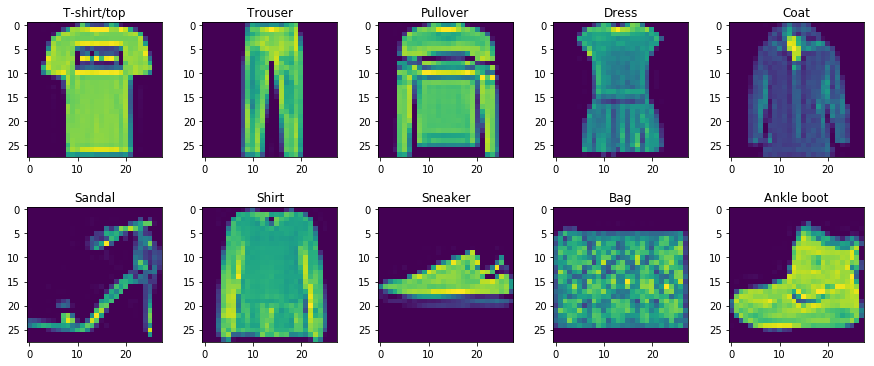

In [12]:
# Utility functions

def flatten(arr):
    arr = arr.reshape(arr.shape[0], -1)
    return arr

def plot_labels(data, labels, flatten=False):

    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    uniq_labels = np.unique(labels)

    fig, ax = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = ax.reshape(-1)

    for i, label in enumerate(uniq_labels):

        img = data[np.where(labels == label)[0][0]]

        ax[i].set_title(class_names[label])
        
        if flatten:
            img = img.reshape(28, 28)

        ax[i].imshow(img)
    
    plt.show()

plot_labels(train_images, train_labels)

In [13]:
train_images = flatten(train_images)
test_images = flatten(test_images)

train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, shuffle=True)

In [14]:
train_labels.shape, val_labels.shape

((54000,), (6000,))

In [15]:
sweep_config = {
  "name": "Sweep Test",
  "method": "grid",
  "parameters": {
        "epochs": {
            "values": [5, 10]
        },
        "n_layers": {
            "values": [3, 4, 5]
        }
    }
}

sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: mbcm7lra
Sweep URL: https://wandb.ai/avyay/uncategorized/sweeps/mbcm7lra


In [16]:
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: dyxs57fe with config:
wandb: 	epochs: 5
wandb: 	n_layers: 3
wandb: Currently logged in as: avyay (use `wandb login --relogin` to force relogin)
C:\Users\rao_a\Miniconda3\envs\PythonCPU\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch: 1 Train Loss: 0.768298 Train Accuracy: 0.718454 Val Loss: 0.476854 Val Accuracy: 0.828956
Epoch: 2 Train Loss: 0.475793 Train Accuracy: 0.828218 Val Loss: 0.437453 Val Accuracy: 0.840758
Epoch: 3 Train Loss: 0.425090 Train Accuracy: 0.846508 Val Loss: 0.422563 Val Accuracy: 0.843584
Epoch: 4 Train Loss: 0.396270 Train Accuracy: 0.856191 Val Loss: 0.400119 Val Accuracy: 0.851729
Epoch: 5 Train Loss: 0.376846 Train Accuracy: 0.863263 Val Loss: 0.380925 Val Accuracy: 0.857879

Model trained successfully!


epoch,5
train_loss,0.37685
train_acc,0.86326
val_loss,0.38092
val_acc,0.85788
_runtime,11
_timestamp,1615400638
_step,4


epoch,▁▃▅▆█
train_loss,█▃▂▁▁
train_acc,▁▆▇██
val_loss,█▅▄▂▁
val_acc,▁▄▅▇█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: ildv3xr9 with config:
wandb: 	epochs: 5
wandb: 	n_layers: 4
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch: 1 Train Loss: 0.789142 Train Accuracy: 0.704421 Val Loss: 0.496390 Val Accuracy: 0.820811
Epoch: 2 Train Loss: 0.471024 Train Accuracy: 0.829254 Val Loss: 0.461163 Val Accuracy: 0.827793
Epoch: 3 Train Loss: 0.419552 Train Accuracy: 0.846897 Val Loss: 0.440672 Val Accuracy: 0.836436
Epoch: 4 Train Loss: 0.390579 Train Accuracy: 0.857394 Val Loss: 0.440443 Val Accuracy: 0.839096
Epoch: 5 Train Loss: 0.369489 Train Accuracy: 0.865392 Val Loss: 0.421357 Val Accuracy: 0.846742

Model trained successfully!


epoch,5
train_loss,0.36949
train_acc,0.86539
val_loss,0.42136
val_acc,0.84674
_runtime,11
_timestamp,1615400654
_step,4


epoch,▁▃▅▆█
train_loss,█▃▂▁▁
train_acc,▁▆▇██
val_loss,█▅▃▃▁
val_acc,▁▃▅▆█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 7siuvidx with config:
wandb: 	epochs: 5
wandb: 	n_layers: 5
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch: 1 Train Loss: 0.911214 Train Accuracy: 0.656194 Val Loss: 0.535093 Val Accuracy: 0.814827
Epoch: 2 Train Loss: 0.499350 Train Accuracy: 0.817110 Val Loss: 0.469705 Val Accuracy: 0.828956
Epoch: 3 Train Loss: 0.438464 Train Accuracy: 0.840121 Val Loss: 0.452654 Val Accuracy: 0.839096
Epoch: 4 Train Loss: 0.405475 Train Accuracy: 0.852229 Val Loss: 0.429550 Val Accuracy: 0.845080
Epoch: 5 Train Loss: 0.383424 Train Accuracy: 0.859782 Val Loss: 0.443397 Val Accuracy: 0.837267

Model trained successfully!


epoch,5
train_loss,0.38342
train_acc,0.85978
val_loss,0.4434
val_acc,0.83727
_runtime,11
_timestamp,1615400672
_step,4


epoch,▁▃▅▆█
train_loss,█▃▂▁▁
train_acc,▁▇▇██
val_loss,█▄▃▁▂
val_acc,▁▄▇█▆
_runtime,▁▂▅▇█
_timestamp,▁▂▅▇█
_step,▁▃▅▆█


wandb: Agent Starting Run: kh9syt6m with config:
wandb: 	epochs: 10
wandb: 	n_layers: 3
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch: 1 Train Loss: 0.738137 Train Accuracy: 0.729376 Val Loss: 0.494812 Val Accuracy: 0.829953
Epoch: 2 Train Loss: 0.471747 Train Accuracy: 0.829069 Val Loss: 0.438561 Val Accuracy: 0.845911
Epoch: 3 Train Loss: 0.419354 Train Accuracy: 0.846397 Val Loss: 0.411195 Val Accuracy: 0.852227
Epoch: 4 Train Loss: 0.390480 Train Accuracy: 0.857468 Val Loss: 0.402800 Val Accuracy: 0.851396
Epoch: 5 Train Loss: 0.371355 Train Accuracy: 0.865114 Val Loss: 0.398703 Val Accuracy: 0.855053
Epoch: 6 Train Loss: 0.356766 Train Accuracy: 0.868835 Val Loss: 0.395170 Val Accuracy: 0.859541
Epoch: 7 Train Loss: 0.345045 Train Accuracy: 0.872556 Val Loss: 0.388275 Val Accuracy: 0.865525
Epoch: 8 Train Loss: 0.335030 Train Accuracy: 0.876518 Val Loss: 0.379982 Val Accuracy: 0.864860
Epoch: 9 Train Loss: 0.326469 Train Accuracy: 0.878536 Val Loss: 0.376264 Val Accuracy: 0.868684
Epoch: 10 Train Loss: 0.318246 Train Accuracy: 0.882812 Val Loss: 0.381000 Val Accuracy: 0.868351

Model trained successfully!


epoch,10
train_loss,0.31825
train_acc,0.88281
val_loss,0.381
val_acc,0.86835
_runtime,18
_timestamp,1615400694
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
train_acc,▁▆▆▇▇▇████
val_loss,█▅▃▃▂▂▂▁▁▁
val_acc,▁▄▅▅▆▆▇▇██
_runtime,▁▂▂▃▄▅▆▇▇█
_timestamp,▁▂▂▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: jb863zkb with config:
wandb: 	epochs: 10
wandb: 	n_layers: 4
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch: 1 Train Loss: 0.770448 Train Accuracy: 0.716473 Val Loss: 0.481271 Val Accuracy: 0.826795
Epoch: 2 Train Loss: 0.484792 Train Accuracy: 0.822997 Val Loss: 0.463583 Val Accuracy: 0.827460
Epoch: 3 Train Loss: 0.432991 Train Accuracy: 0.841973 Val Loss: 0.443556 Val Accuracy: 0.834608
Epoch: 4 Train Loss: 0.403062 Train Accuracy: 0.852340 Val Loss: 0.415214 Val Accuracy: 0.845745
Epoch: 5 Train Loss: 0.382534 Train Accuracy: 0.859893 Val Loss: 0.404023 Val Accuracy: 0.848737
Epoch: 6 Train Loss: 0.366540 Train Accuracy: 0.866354 Val Loss: 0.405202 Val Accuracy: 0.851230
Epoch: 7 Train Loss: 0.353609 Train Accuracy: 0.870964 Val Loss: 0.412931 Val Accuracy: 0.848737
Epoch: 8 Train Loss: 0.342999 Train Accuracy: 0.875222 Val Loss: 0.396952 Val Accuracy: 0.852726
Epoch: 9 Train Loss: 0.334706 Train Accuracy: 0.877185 Val Loss: 0.391934 Val Accuracy: 0.853059
Epoch: 10 Train Loss: 0.325863 Train Accuracy: 0.880906 Val Loss: 0.378297 Val Accuracy: 0.860372

Model trained successfully!


epoch,10
train_loss,0.32586
train_acc,0.88091
val_loss,0.3783
val_acc,0.86037
_runtime,17
_timestamp,1615400716
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
train_acc,▁▆▆▇▇▇████
val_loss,█▇▅▄▃▃▃▂▂▁
val_acc,▁▁▃▅▆▆▆▆▆█
_runtime,▁▂▂▃▄▅▆▇▇█
_timestamp,▁▂▂▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 2y8ju2so with config:
wandb: 	epochs: 10
wandb: 	n_layers: 5
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch: 1 Train Loss: 0.810174 Train Accuracy: 0.698811 Val Loss: 0.503416 Val Accuracy: 0.822972
Epoch: 2 Train Loss: 0.490076 Train Accuracy: 0.820572 Val Loss: 0.455052 Val Accuracy: 0.835771
Epoch: 3 Train Loss: 0.432547 Train Accuracy: 0.840640 Val Loss: 0.404811 Val Accuracy: 0.856715
Epoch: 4 Train Loss: 0.400104 Train Accuracy: 0.852507 Val Loss: 0.393717 Val Accuracy: 0.859707
Epoch: 5 Train Loss: 0.379116 Train Accuracy: 0.860467 Val Loss: 0.383087 Val Accuracy: 0.863032
Epoch: 6 Train Loss: 0.361949 Train Accuracy: 0.866669 Val Loss: 0.389227 Val Accuracy: 0.861702
Epoch: 7 Train Loss: 0.349031 Train Accuracy: 0.870835 Val Loss: 0.382188 Val Accuracy: 0.865858
Epoch: 8 Train Loss: 0.337438 Train Accuracy: 0.875555 Val Loss: 0.386462 Val Accuracy: 0.864195
Epoch: 9 Train Loss: 0.329140 Train Accuracy: 0.878332 Val Loss: 0.385880 Val Accuracy: 0.866689
Epoch: 10 Train Loss: 0.320581 Train Accuracy: 0.881720 Val Loss: 0.370321 Val Accuracy: 0.868850

Model trained successfully!


epoch,10
train_loss,0.32058
train_acc,0.88172
val_loss,0.37032
val_acc,0.86885
_runtime,17
_timestamp,1615400738
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
train_acc,▁▆▆▇▇▇████
val_loss,█▅▃▂▂▂▂▂▂▁
val_acc,▁▃▆▇▇▇█▇██
_runtime,▁▂▂▃▄▅▅▆▇█
_timestamp,▁▂▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
